# FrameDataset Usage Guide
# FrameDataset 使用ガイド

This notebook demonstrates how to use the `FrameDataset` class for efficient batch processing of audio files.

このノートブックでは、`FrameDataset` クラスを使用して音声ファイルのバッチ処理を効率的に行う方法を示します。

## Overview / 概要

`FrameDataset` is an abstract base class for handling multiple audio files in a folder. The main concrete implementations are:
- `ChannelFrameDataset`: For time-domain audio data
- `SpectrogramFrameDataset`: For time-frequency domain data (typically created from `ChannelFrameDataset.stft()`)

`FrameDataset` は、フォルダ内の複数の音声ファイルを扱うための抽象基底クラスです。主な具象実装は以下の通りです：
- `ChannelFrameDataset`: 時間領域の音声データ用
- `SpectrogramFrameDataset`: 時間周波数領域データ用（通常は `ChannelFrameDataset.stft()` から作成）

## Key Features / 主な機能

- **Lazy Loading**: Efficient memory usage by loading files only when needed
- **Transformation Chaining**: Apply multiple transformations efficiently
- **Sampling**: Extract subsets of data for testing or analysis
- **Metadata Tracking**: Keep track of dataset properties and processing history

- **遅延読み込み**: 必要なときだけファイルを読み込むことでメモリ効率を向上
- **変換のチェーン**: 複数の変換を効率的に適用
- **サンプリング**: テストや分析のためにデータのサブセットを抽出
- **メタデータ追跡**: データセットのプロパティと処理履歴を追跡

## Setup / セットアップ

In [1]:
import wandas as wd
from wandas.utils.frame_dataset import ChannelFrameDataset, SpectrogramFrameDataset
import numpy as np
import matplotlib.pyplot as plt

# For this example, we'll create some sample audio files
# この例では、サンプル音声ファイルを作成します
import tempfile
import os
from pathlib import Path

In [2]:
# Create a temporary directory with sample audio files
# サンプル音声ファイルを含む一時ディレクトリを作成
temp_dir = tempfile.mkdtemp()
print(f"Created temporary directory: {temp_dir}")

# Generate and save sample audio files
# サンプル音声ファイルを生成して保存
sampling_rate = 16000
duration = 2.0  # seconds

for i in range(5):
    # Generate a sine wave with different frequencies
    # 異なる周波数の正弦波を生成
    freq = 440 * (i + 1)  # A4, A5, etc.
    signal = wd.generate_sin(freqs=[freq], duration=duration, sampling_rate=sampling_rate)

    # Save as WAV file
    # WAVファイルとして保存
    filename = os.path.join(temp_dir, f"sample_{i+1}.wav")
    signal.to_wav(filename)
    print(f"Created: {filename}")

# Create a subdirectory for testing recursive loading
# 再帰的読み込みテスト用のサブディレクトリを作成
sub_dir = os.path.join(temp_dir, "subdir")
os.makedirs(sub_dir)

for i in range(2):
    freq = 880 * (i + 1)
    signal = wd.generate_sin(freqs=[freq], duration=duration, sampling_rate=sampling_rate)
    filename = os.path.join(sub_dir, f"sub_sample_{i+1}.wav")
    signal.to_wav(filename)
    print(f"Created: {filename}")

Created temporary directory: /tmp/tmpc8xt6c6p
Created: /tmp/tmpc8xt6c6p/sample_1.wav
Created: /tmp/tmpc8xt6c6p/sample_2.wav
Created: /tmp/tmpc8xt6c6p/sample_3.wav
Created: /tmp/tmpc8xt6c6p/sample_4.wav
Created: /tmp/tmpc8xt6c6p/sample_5.wav
Created: /tmp/tmpc8xt6c6p/subdir/sub_sample_1.wav
Created: /tmp/tmpc8xt6c6p/subdir/sub_sample_2.wav


## 1. Basic Initialization / 基本的な初期化

### 1.1 Creating a ChannelFrameDataset

The most common way to create a dataset is using the `from_folder` class method or direct initialization.

データセットを作成する最も一般的な方法は、`from_folder` クラスメソッドまたは直接初期化です。

In [3]:
# Method 1: Using from_folder (recommended)
# 方法1: from_folder を使用（推奨）
dataset = ChannelFrameDataset.from_folder(
    folder_path=temp_dir,
    sampling_rate=None,  # Keep original sampling rate / 元のサンプリングレートを維持
    file_extensions=[".wav"],  # File types to load / 読み込むファイルタイプ
    recursive=False,  # Don't search subdirectories / サブディレクトリを検索しない
    lazy_loading=True  # Load files on demand / 必要に応じてファイルを読み込む
)

print(f"Dataset created with {len(dataset)} files")
print(f"データセットが {len(dataset)} ファイルで作成されました")

Dataset created with 5 files
データセットが 5 ファイルで作成されました


In [4]:
# Method 2: Direct initialization
# 方法2: 直接初期化
dataset_direct = ChannelFrameDataset(
    folder_path=temp_dir,
    file_extensions=[".wav"],
    lazy_loading=True,
    recursive=False
)

print(f"Direct initialization: {len(dataset_direct)} files")

Direct initialization: 5 files


### 1.2 Important Parameters / 重要なパラメータ

**folder_path**: Path to the folder containing audio files  
音声ファイルを含むフォルダへのパス

**sampling_rate**: Target sampling rate (files will be resampled if different)  
目標サンプリングレート（異なる場合はリサンプリングされます）

**file_extensions**: List of file extensions to include (default: `[".wav", ".mp3", ".flac", ".csv"]`)  
含めるファイル拡張子のリスト（デフォルト: `[".wav", ".mp3", ".flac", ".csv"]`）

**lazy_loading**: If True, files are loaded only when accessed (default: True)  
True の場合、アクセス時のみファイルを読み込む（デフォルト: True）

**recursive**: If True, search subdirectories recursively  
True の場合、サブディレクトリを再帰的に検索

In [5]:
# Example: Recursive loading
# 例: 再帰的読み込み
dataset_recursive = ChannelFrameDataset.from_folder(
    folder_path=temp_dir,
    recursive=True  # Include files in subdirectories / サブディレクトリのファイルも含める
)

print(f"Non-recursive dataset: {len(dataset)} files")
print(f"Recursive dataset: {len(dataset_recursive)} files")
print(f"非再帰的データセット: {len(dataset)} ファイル")
print(f"再帰的データセット: {len(dataset_recursive)} ファイル")

Non-recursive dataset: 5 files
Recursive dataset: 7 files
非再帰的データセット: 5 ファイル
再帰的データセット: 7 ファイル


## 2. Accessing Files / ファイルへのアクセス

### 2.1 Getting Individual Frames / 個別のフレームを取得

Use the `__getitem__` method (indexing) to access individual frames.

`__getitem__` メソッド（インデックス）を使用して個別のフレームにアクセスします。

Label: sample_1
Sampling rate: 16000 Hz
Duration: 2.00 seconds
Channels: 1


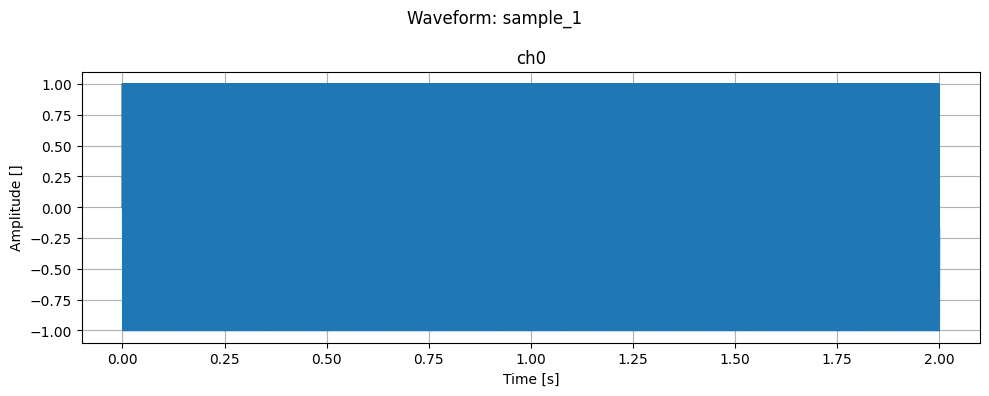

In [6]:
# Access the first file
# 最初のファイルにアクセス
first_frame = dataset[0]

if first_frame is not None:
    print(f"Label: {first_frame.label}")
    print(f"Sampling rate: {first_frame.sampling_rate} Hz")
    print(f"Duration: {first_frame.duration:.2f} seconds")
    print(f"Channels: {first_frame.n_channels}")

    # Plot the waveform
    # 波形をプロット
    first_frame.plot(title=f"Waveform: {first_frame.label}")

### 2.2 Lazy Loading Demonstration / 遅延読み込みのデモンストレーション

With lazy loading, files are only loaded when accessed. This is efficient for large datasets.

遅延読み込みでは、アクセス時にのみファイルが読み込まれます。大規模データセットに効率的です。

In [7]:
# Create a fresh dataset to demonstrate lazy loading
# 遅延読み込みをデモンストレーションするため、新しいデータセットを作成
fresh_dataset = ChannelFrameDataset.from_folder(
    folder_path=temp_dir,
    file_extensions=[".wav"],
    lazy_loading=True,
    recursive=False
)

# Get metadata before accessing any files
# ファイルにアクセスする前にメタデータを取得
metadata_before = fresh_dataset.get_metadata()
print("Before accessing files:")
print(f"  Loaded count: {metadata_before['loaded_count']} / {metadata_before['file_count']}")

# Access a file
# ファイルにアクセス
_ = fresh_dataset[0]

# Get metadata after accessing one file
# 1つのファイルにアクセスした後のメタデータを取得
metadata_after = fresh_dataset.get_metadata()
print("\nAfter accessing one file:")
print(f"  Loaded count: {metadata_after['loaded_count']} / {metadata_after['file_count']}")


Before accessing files:
  Loaded count: 0 / 5

After accessing one file:
  Loaded count: 1 / 5


### 2.3 Iterating Over the Dataset / データセットの反復処理

In [8]:
# Iterate over all files in the dataset
# データセット内のすべてのファイルを反復処理
print("Files in dataset:")
for i in range(len(dataset)):
    frame = dataset[i]
    if frame is not None:
        print(f"  [{i}] {frame.label} - {frame.duration:.2f}s")

Files in dataset:
  [0] sample_1 - 2.00s
  [1] sample_2 - 2.00s
  [2] sample_3 - 2.00s
  [3] sample_4 - 2.00s
  [4] sample_5 - 2.00s


## 3. Sampling / サンプリング

### 3.1 Random Sampling / ランダムサンプリング

The `sample` method allows you to extract a random subset of the dataset.

`sample` メソッドを使用すると、データセットのランダムなサブセットを抽出できます。

In [9]:
# Sample by number of files
# ファイル数でサンプリング
sampled_dataset = dataset.sample(n=3, seed=42)

print(f"Original dataset: {len(dataset)} files")
print(f"Sampled dataset: {len(sampled_dataset)} files")
print(f"元のデータセット: {len(dataset)} ファイル")
print(f"サンプリングされたデータセット: {len(sampled_dataset)} ファイル")

# Show sampled files
# サンプリングされたファイルを表示
print("\nSampled files:")
for i in range(len(sampled_dataset)):
    frame = sampled_dataset[i]
    if frame is not None:
        print(f"  {frame.label}")

Original dataset: 5 files
Sampled dataset: 3 files
元のデータセット: 5 ファイル
サンプリングされたデータセット: 3 ファイル

Sampled files:
  sample_1
  sample_3
  sample_5


In [10]:
# Sample by ratio
# 比率でサンプリング
sampled_by_ratio = dataset.sample(ratio=0.5, seed=123)

print(f"Sampling 50% of {len(dataset)} files: {len(sampled_by_ratio)} files")
print(f"{len(dataset)} ファイルの50%をサンプリング: {len(sampled_by_ratio)} ファイル")

Sampling 50% of 5 files: 2 files
5 ファイルの50%をサンプリング: 2 ファイル


In [11]:
# Default sampling (10% or minimum 1 file)
# デフォルトサンプリング（10%または最小1ファイル）
default_sample = dataset.sample(seed=999)

print(f"Default sample: {len(default_sample)} files")
print(f"デフォルトサンプル: {len(default_sample)} ファイル")

Default sample: 1 files
デフォルトサンプル: 1 ファイル


### 3.2 Reproducible Sampling / 再現可能なサンプリング

Use the `seed` parameter for reproducible random sampling.

再現可能なランダムサンプリングには `seed` パラメータを使用します。

In [12]:
# Sample with same seed produces same results
# 同じシードでサンプリングすると同じ結果が得られる
sample1 = dataset.sample(n=2, seed=42)
sample2 = dataset.sample(n=2, seed=42)

print("Sample 1:")
for i in range(len(sample1)):
    frame = sample1[i]
    if frame:
        print(f"  {frame.label}")

print("\nSample 2 (same seed):")
for i in range(len(sample2)):
    frame = sample2[i]
    if frame:
        print(f"  {frame.label}")

Sample 1:
  sample_1
  sample_5

Sample 2 (same seed):
  sample_1
  sample_5


## 4. Applying Transformations / 変換の適用

### 4.1 Basic Transformations / 基本的な変換

The `apply` method allows you to apply a function to all frames in the dataset.

`apply` メソッドを使用すると、データセット内のすべてのフレームに関数を適用できます。

In [13]:
# Apply a custom transformation
# カスタム変換を適用
def amplify(frame):
    """Amplify the signal by a factor of 2."""
    return frame * 2.0

# Apply the transformation (lazy evaluation)
# 変換を適用（遅延評価）
amplified_dataset = dataset.apply(amplify)

print(f"Transformation applied (not yet computed)")
print(f"変換が適用されました（まだ計算されていません）")

# Access a frame to trigger computation
# フレームにアクセスして計算をトリガー
original_frame = dataset[0]
amplified_frame = amplified_dataset[0]

if original_frame and amplified_frame:
    print(f"\nOriginal max amplitude: {np.max(np.abs(original_frame.compute())):.4f}")
    print(f"Amplified max amplitude: {np.max(np.abs(amplified_frame.compute())):.4f}")

Transformation applied (not yet computed)
変換が適用されました（まだ計算されていません）

Original max amplitude: 1.0000
Amplified max amplitude: 2.0000

Original max amplitude: 1.0000
Amplified max amplitude: 2.0000


### 4.2 Built-in Transformations / 組み込み変換

`ChannelFrameDataset` provides several built-in transformation methods.

`ChannelFrameDataset` はいくつかの組み込み変換メソッドを提供します。

In [14]:
# Resample to a different sampling rate
# 異なるサンプリングレートにリサンプリング
resampled_dataset = dataset.resample(target_sr=8000)

original_sr = dataset[0].sampling_rate if dataset[0] else None
resampled_sr = resampled_dataset[0].sampling_rate if resampled_dataset[0] else None

print(f"Original sampling rate: {original_sr} Hz")
print(f"Resampled sampling rate: {resampled_sr} Hz")

Original sampling rate: 16000 Hz
Resampled sampling rate: 8000 Hz


In [15]:
# Trim audio files
# 音声ファイルをトリミング
trimmed_dataset = dataset.trim(start=0.2, end=1.5)

trimmed_frame = trimmed_dataset[0]
if trimmed_frame:
    print(f"Original duration: {dataset[0].duration:.2f}s" if dataset[0] else "")
    print(f"元の長さ: {dataset[0].duration:.2f}秒" if dataset[0] else "")
    print(f"Trimmed duration: {trimmed_frame.duration:.2f}s")
    print(f"トリミング後の長さ: {trimmed_frame.duration:.2f}秒")

Original duration: 2.00s
元の長さ: 2.00秒
Trimmed duration: 1.30s
トリミング後の長さ: 1.30秒


### 4.3 Chaining Transformations / 変換のチェーン

Multiple transformations can be chained together efficiently.

複数の変換を効率的にチェーンできます。

Processed frame:
処理されたフレーム:
  Sampling rate: 8000 Hz
  サンプリングレート: 8000 Hz
  Duration: 1.00s
  長さ: 1.00秒


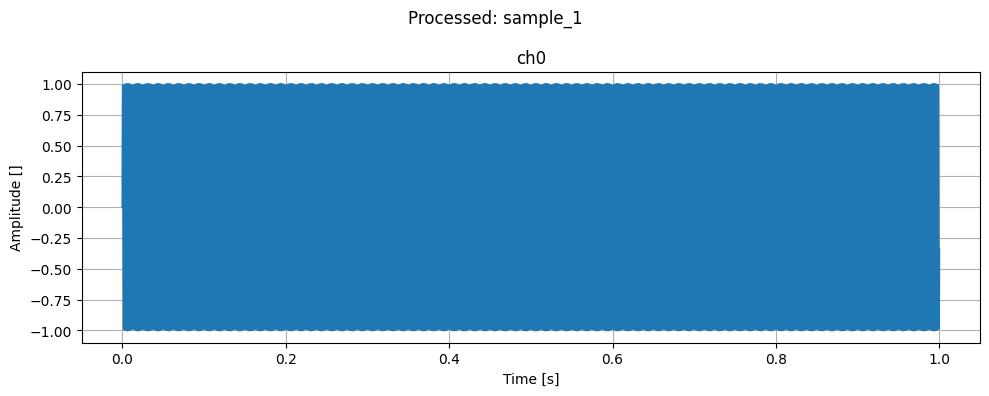

In [16]:
# Chain multiple transformations
# 複数の変換をチェーン
processed_dataset = (
    dataset
    .resample(target_sr=8000)  # Resample to 8 kHz
    .trim(start=0.5, end=1.5)   # Keep 1 second from 0.5s to 1.5s
    .normalize()                 # Normalize audio levels
)

# Access a processed frame
# 処理されたフレームにアクセス
processed_frame = processed_dataset[0]

if processed_frame:
    print(f"Processed frame:")
    print(f"処理されたフレーム:")
    print(f"  Sampling rate: {processed_frame.sampling_rate} Hz")
    print(f"  サンプリングレート: {processed_frame.sampling_rate} Hz")
    print(f"  Duration: {processed_frame.duration:.2f}s")
    print(f"  長さ: {processed_frame.duration:.2f}秒")

    processed_frame.plot(title=f"Processed: {processed_frame.label}")

### 4.4 STFT - Converting to Spectrogram / STFT - スペクトログラムへの変換

The `stft` method creates a `SpectrogramFrameDataset` from the time-domain data.

`stft` メソッドは、時間領域データから `SpectrogramFrameDataset` を作成します。

Type: SpectrogramFrameDataset
Number of files: 5

Spectrogram shape: (1025, 66)
FFT size: 2048
Hop length: 512


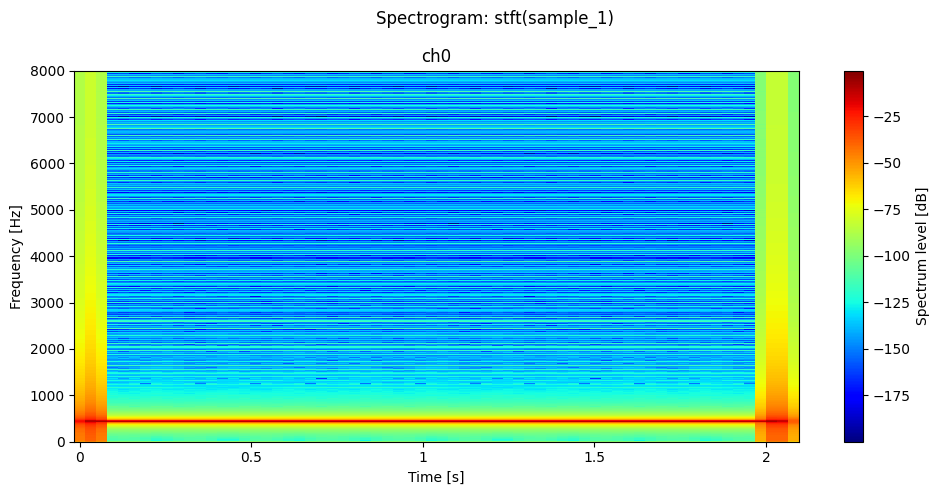

In [17]:
# Apply STFT to create spectrograms
# STFTを適用してスペクトログラムを作成
spectrogram_dataset = dataset.stft(
    n_fft=2048,
    hop_length=512,
    window="hann"
)

print(f"Type: {type(spectrogram_dataset).__name__}")
print(f"Number of files: {len(spectrogram_dataset)}")

# Access and plot a spectrogram
# スペクトログラムにアクセスしてプロット
spec_frame = spectrogram_dataset[0]

if spec_frame:
    print(f"\nSpectrogram shape: {spec_frame.shape}")
    print(f"FFT size: {spec_frame.n_fft}")
    print(f"Hop length: {spec_frame.hop_length}")

    spec_frame.plot(title=f"Spectrogram: {spec_frame.label}")

## 5. Metadata and Dataset Information / メタデータとデータセット情報

### 5.1 Getting Dataset Metadata / データセットのメタデータを取得

The `get_metadata` method provides comprehensive information about the dataset.

`get_metadata` メソッドは、データセットに関する包括的な情報を提供します。

In [18]:
# Get metadata for the original dataset
# 元のデータセットのメタデータを取得
metadata = dataset.get_metadata()

print("Dataset Metadata:")
for key, value in metadata.items():
    print(f"  {key}: {value}")

Dataset Metadata:
  folder_path: /tmp/tmpc8xt6c6p
  file_count: 5
  loaded_count: 5
  target_sampling_rate: None
  actual_sampling_rate: 16000
  signal_length: None
  file_extensions: ['.wav']
  lazy_loading: True
  recursive: False
  frame_type: ChannelFrame
  has_transform: False
  is_sampled: False


In [19]:
# Get metadata for a transformed dataset
# 変換されたデータセットのメタデータを取得
transformed_metadata = processed_dataset.get_metadata()

print("\nTransformed Dataset Metadata:")
for key, value in transformed_metadata.items():
    print(f"  {key}: {value}")


Transformed Dataset Metadata:
  folder_path: /tmp/tmpc8xt6c6p
  file_count: 5
  loaded_count: 1
  target_sampling_rate: None
  actual_sampling_rate: 8000
  signal_length: None
  file_extensions: ['.wav']
  lazy_loading: True
  recursive: False
  frame_type: ChannelFrame
  has_transform: True
  is_sampled: False


## 6. Advanced Usage / 高度な使用法

### 6.1 Combining Sampling and Transformation / サンプリングと変換の組み合わせ

In [20]:
# Sample a subset and apply transformations
# サブセットをサンプリングして変換を適用
# Note: Use apply() with lambda functions since _SampledFrameDataset doesn't have convenience methods
# 注意: _SampledFrameDataset には便利メソッドがないため、apply() とラムダ関数を使用します
sampled_subset = dataset.sample(n=3, seed=42)

# Apply transformations using apply() and lambda functions
# apply() とラムダ関数を使用して変換を適用
sampled_and_processed = (
    sampled_subset
    .apply(lambda frame: frame.resampling(target_sr=8000) if frame else None)
    .apply(lambda frame: frame.trim(start=0.2, end=1.0) if frame else None)
)

print(f"Sampled and processed dataset: {len(sampled_and_processed)} files")
print(f"サンプリングおよび処理されたデータセット: {len(sampled_and_processed)} ファイル")

# Process all sampled files
# すべてのサンプリングされたファイルを処理
for i in range(len(sampled_and_processed)):
    frame = sampled_and_processed[i]
    if frame:
        print(f"  {frame.label}: {frame.sampling_rate}Hz, {frame.duration:.2f}s")

Sampled and processed dataset: 3 files
サンプリングおよび処理されたデータセット: 3 ファイル
  sample_1: 8000Hz, 0.80s
  sample_3: 8000Hz, 0.80s
  sample_5: 8000Hz, 0.80s


### 6.2 Custom Processing Function / カスタム処理関数

Custom processed frame: sample_1
カスタム処理されたフレーム: sample_1


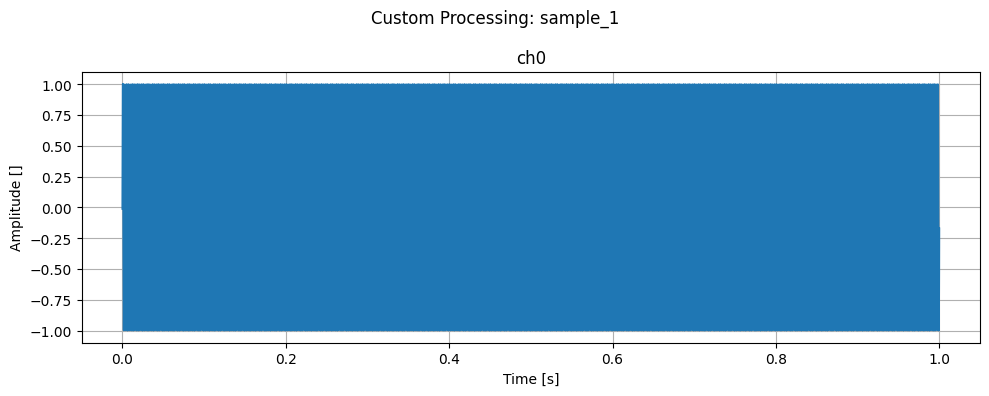

In [21]:
# Define a custom processing function
# カスタム処理関数を定義
def custom_processing(frame):
    """
    Custom processing: apply low-pass filter and trim.

    カスタム処理: ローパスフィルタを適用してトリミングします。
    """
    # Apply low-pass filter at 1000 Hz
    # 1000 Hz でローパスフィルタを適用
    filtered = frame.low_pass_filter(cutoff=1000)

    # Trim to first second
    # 最初の1秒にトリミング
    trimmed = filtered.trim(start=0, end=1.0)

    return trimmed

# Apply custom processing
# カスタム処理を適用
custom_dataset = dataset.apply(custom_processing)

# Access a processed frame
# 処理されたフレームにアクセス
custom_frame = custom_dataset[0]

if custom_frame:
    print(f"Custom processed frame: {custom_frame.label}")
    print(f"カスタム処理されたフレーム: {custom_frame.label}")
    custom_frame.plot(title=f"Custom Processing: {custom_frame.label}")

### 6.3 Working with SpectrogramFrameDataset / SpectrogramFrameDataset の操作

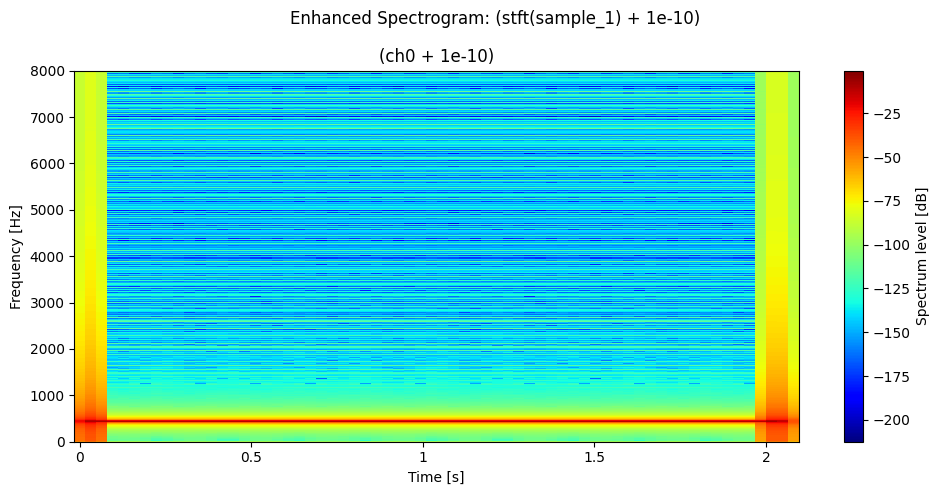

In [22]:
# Apply transformations to spectrogram dataset
# スペクトログラムデータセットに変換を適用
def enhance_spectrogram(spec_frame):
    """
    Enhance spectrogram by adding a small constant.

    小さな定数を追加してスペクトログラムを強調します。
    """
    return spec_frame + 1e-10  # Add small constant to avoid log(0)

# Apply to spectrogram dataset
# スペクトログラムデータセットに適用
enhanced_spec_dataset = spectrogram_dataset.apply(enhance_spectrogram)

# Access and visualize
# アクセスして可視化
enhanced_spec = enhanced_spec_dataset[0]

if enhanced_spec:
    enhanced_spec.plot(title=f"Enhanced Spectrogram: {enhanced_spec.label}")

## 7. Best Practices / ベストプラクティス

### 7.1 Memory Efficiency / メモリ効率

- Always use `lazy_loading=True` for large datasets
- Access only the files you need
- Use sampling to test processing pipelines before applying to the full dataset

- 大規模データセットには常に `lazy_loading=True` を使用する
- 必要なファイルのみにアクセスする
- 完全なデータセットに適用する前に、サンプリングを使用して処理パイプラインをテストする

In [23]:
# Example: Test processing on a small sample first
# 例: 最初に小さなサンプルで処理をテスト
test_sample = dataset.sample(n=2, seed=42)
# Use apply() for transformations on sampled datasets
# サンプリングされたデータセットには apply() を使用
test_processed = (
    test_sample
    .apply(lambda frame: frame.resampling(target_sr=8000) if frame else None)
    .apply(lambda frame: frame.trim(start=0.2, end=1.0) if frame else None)
)

# Verify the processing works as expected
# 処理が期待通りに動作することを確認
test_frame = test_processed[0]
if test_frame:
    print(f"Test processing successful: {test_frame.label}")
    print(f"テスト処理成功: {test_frame.label}")
    print(f"  Sampling rate: {test_frame.sampling_rate}")
    print(f"  サンプリングレート: {test_frame.sampling_rate}")
    print(f"  Duration: {test_frame.duration:.2f}s")
    print(f"  長さ: {test_frame.duration:.2f}秒")

# If satisfied, apply to full dataset
# 満足できる場合は、完全なデータセットに適用
# For full dataset, you can use convenience methods directly
# 完全なデータセットには、便利メソッドを直接使用できます
full_processed = dataset.resample(target_sr=8000).trim(start=0.2, end=1.0)
print(f"\nProcessing pipeline ready for {len(full_processed)} files")
print(f"\n{len(full_processed)} ファイルの処理パイプラインの準備完了")

Test processing successful: sample_1
テスト処理成功: sample_1
  Sampling rate: 8000
  サンプリングレート: 8000
  Duration: 0.80s
  長さ: 0.80秒

Processing pipeline ready for 5 files

5 ファイルの処理パイプラインの準備完了


### 7.2 Error Handling / エラーハンドリング

Always check if frames are `None` before processing, as file loading can fail.

ファイルの読み込みに失敗する可能性があるため、処理前にフレームが `None` でないか常に確認してください。

In [24]:
# Safe way to process frames
# フレームを安全に処理する方法
for i in range(len(dataset)):
    frame = dataset[i]

    if frame is None:
        print(f"Warning: Failed to load frame at index {i}")
        continue

    # Process the frame
    # フレームを処理
    print(f"Processing {frame.label}...")

Processing sample_1...
Processing sample_2...
Processing sample_3...
Processing sample_4...
Processing sample_5...


## 8. Cleanup / クリーンアップ

Clean up temporary files created for this example.

この例で作成した一時ファイルをクリーンアップします。

In [25]:
# Clean up temporary directory
# 一時ディレクトリをクリーンアップ
import shutil

try:
    shutil.rmtree(temp_dir)
    print(f"Cleaned up temporary directory: {temp_dir}")
except Exception as e:
    print(f"Failed to clean up: {e}")

Cleaned up temporary directory: /tmp/tmpc8xt6c6p


## Summary / まとめ

This notebook demonstrated the key features of `FrameDataset`:

1. **Initialization**: Creating datasets from folders with various options
2. **Accessing Data**: Using indexing and iteration to access frames
3. **Sampling**: Extracting random subsets for testing or analysis
4. **Transformations**: Applying processing operations lazily and efficiently
5. **Metadata**: Tracking dataset properties and processing history
6. **Advanced Usage**: Combining operations for complex workflows

このノートブックでは、`FrameDataset` の主な機能を実演しました：

1. **初期化**: さまざまなオプションでフォルダからデータセットを作成
2. **データへのアクセス**: インデックスと反復処理を使用してフレームにアクセス
3. **サンプリング**: テストや分析のためにランダムなサブセットを抽出
4. **変換**: 処理操作を遅延的かつ効率的に適用
5. **メタデータ**: データセットのプロパティと処理履歴を追跡
6. **高度な使用法**: 複雑なワークフローのために操作を組み合わせる

For more information, refer to the [API documentation](https://kasahart.github.io/wandas/).

詳細については、[APIドキュメント](https://kasahart.github.io/wandas/)を参照してください。